In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/MyDrive/Kvasir'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image
import os
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [ ]:
#Defining paths
TRAIN_PATH = "/content/drive/MyDrive/Kvasir/Train"
TEST_PATH = "/content/drive/MyDrive/Kvasir/Test"

In [ ]:
BATCH_SIZE = 64

train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=40, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, fill_mode="nearest", validation_split=0.1)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validation_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 6480 images belonging to 8 classes.
Found 720 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [ ]:
from tensorflow.keras.layers import Flatten,Conv2D,MaxPooling2D,LSTM,Dropout,TimeDistributed

In [ ]:
from keras.models import Model
from keras.layers import Input

In [ ]:
def create_model():
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.

    #target = keras.layers.Reshape(target_shape = (-1 ,224 , 224, 3), input_shape=(224,224,3)

    pre_trained_model = InceptionV3(input_shape=(224,224,3), include_top = False, weights = 'imagenet')

    for layer in pre_trained_model.layers[:-3]:
            layer.trainable = False
    for layer in pre_trained_model.layers[-3:]:
            layer.trainable = True
    
    #keras.layers.Reshape(target_shape = (-1 ,224 , 224, 3), input_shape=(224,224,3)
    x = keras.layers.Reshape(target_shape = (-1,224,224,3))(pre_trained_model.input)
    cnn_model = TimeDistributed(pre_trained_model)(x)
    cnn_model = TimeDistributed(keras.layers.Flatten())(cnn_model)
    cnn_model = TimeDistributed(Dense(1024,activation='relu'))(cnn_model)
    cnn_model = TimeDistributed(Dropout(0.5))(cnn_model)
    cnn_model = TimeDistributed(keras.layers.BatchNormalization())(cnn_model)
    #LSTM
    top_model = LSTM(200, activation='tanh', dropout=0.2, return_sequences=True)(cnn_model)
    top_model = LSTM(100, activation='tanh', dropout=0.2, return_sequences=True)(top_model)
    top_model = LSTM(50, activation='tanh', dropout=0.2, return_sequences=False)(top_model)

    top_model = Dense(128,activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = keras.layers.BatchNormalization()(top_model)
    top_model = Dense(64,activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = keras.layers.BatchNormalization()(top_model)
    top_model = Dense(32,activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = keras.layers.BatchNormalization()(top_model)
    output_layer = Dense(8, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    #model = Model([target], output_layer)
    model = Model(inputs=pre_trained_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 1e-4, decay=1e-4/30), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
InceptionV3_model = create_model()

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
InceptionV3_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 reshape (Reshape)           (None, 1, 224, 224, 3)    0         
                                                                 
 time_distributed (TimeDistr  (None, 1, 5, 5, 2048)    21802784  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 51200)         0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 1024)          52429824  
 tributed)                                                       
                                                             

In [ ]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')
#CNN - Spatial features
#LSTM - Sequential information

In [ ]:
InceptionV3_history = InceptionV3_model.fit(train_generator,
                            batch_size=BATCH_SIZE,
                            epochs=30,
                            validation_data=validation_generator,
                            callbacks=[tl_checkpoint_1, early_stop],
                            verbose=1)

Epoch 1/30
102/102 [==============================] - ETA: 0s - loss: 2.5503 - accuracy: 0.1406 
Epoch 1: val_loss improved from inf to 2.10785, saving model to tl_model_v1.weights.best.hdf5
102/102 [==============================] - 2868s 28s/step - loss: 2.5503 - accuracy: 0.1406 - val_loss: 2.1079 - val_accuracy: 0.1250
Epoch 2/30
102/102 [==============================] - ETA: 0s - loss: 2.3198 - accuracy: 0.1873
Epoch 2: val_loss did not improve from 2.10785
102/102 [==============================] - 193s 2s/step - loss: 2.3198 - accuracy: 0.1873 - val_loss: 2.1095 - val_accuracy: 0.1250
Epoch 3/30
102/102 [==============================] - ETA: 0s - loss: 2.1672 - accuracy: 0.2176
Epoch 3: val_loss improved from 2.10785 to 2.08021, saving model to tl_model_v1.weights.best.hdf5
102/102 [==============================] - 193s 2s/step - loss: 2.1672 - accuracy: 0.2176 - val_loss: 2.0802 - val_accuracy: 0.1250
Epoch 4/30
102/102 [==============================] - ETA: 0s - loss: 2.02

In [ ]:
# Generate predictions
InceptionV3_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

In [ ]:
true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

InceptionV3_preds = InceptionV3_model.predict(test_generator)
InceptionV3_pred_classes = np.argmax(InceptionV3_preds, axis=1)

800/800 [==============================] - 382s 474ms/step


In [ ]:
from sklearn.metrics import accuracy_score
InceptionV3_acc = accuracy_score(true_classes, InceptionV3_pred_classes)
print("InceptionV3 Model Accuracy: {:.2f}%".format(InceptionV3_acc * 100))

InceptionV3 Model Accuracy: 84.00%


In [ ]:
labels = os.listdir(TRAIN_PATH)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_classes,InceptionV3_pred_classes,target_names = labels))

                        precision    recall  f1-score   support

         normal-z-line       0.81      0.75      0.78       100
        normal-pylorus       0.79      0.84      0.82       100
dyed-resection-margins       0.81      0.64      0.72       100
          normal-cecum       0.88      0.92      0.90       100
    ulcerative-colitis       0.90      0.96      0.93       100
                polyps       0.71      0.84      0.77       100
           esophagitis       0.92      0.86      0.89       100
    dyed-lifted-polyps       0.92      0.91      0.91       100

              accuracy                           0.84       800
             macro avg       0.84      0.84      0.84       800
          weighted avg       0.84      0.84      0.84       800



In [ ]:
from sklearn.metrics import precision_score
precision_score(true_classes, InceptionV3_pred_classes, average='micro')

0.84

In [ ]:
from sklearn.metrics import recall_score
recall_score(true_classes, InceptionV3_pred_classes, average='micro')

0.84

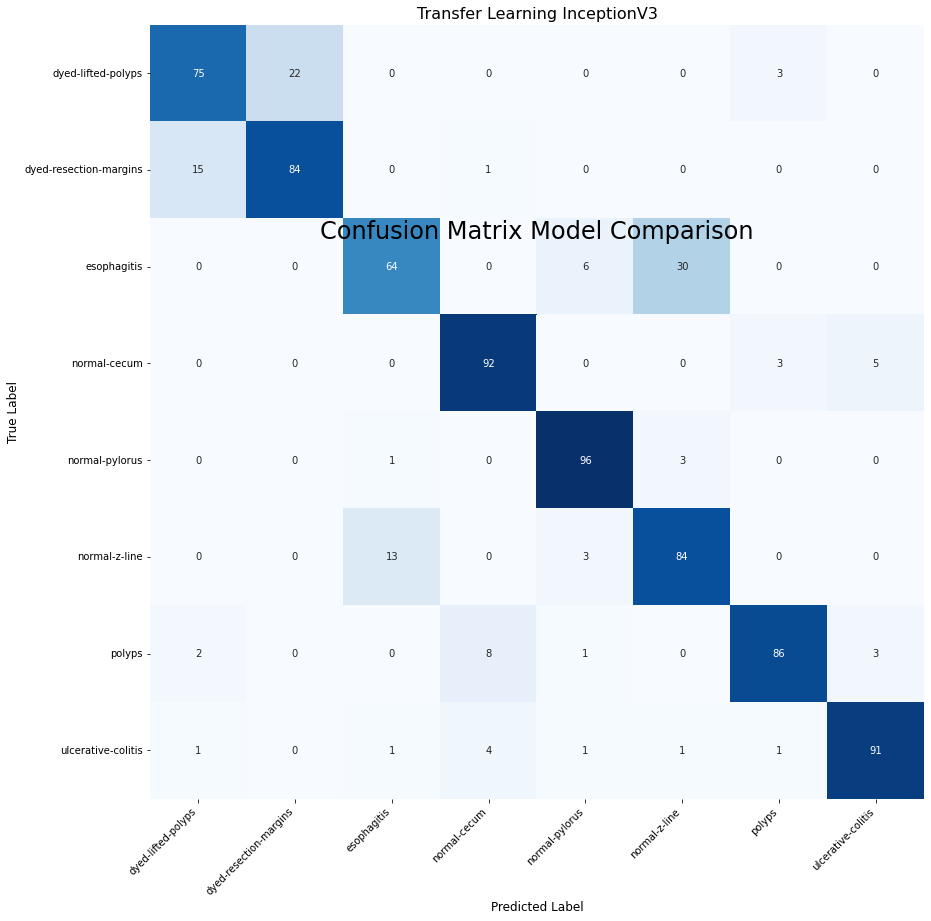

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1,figsize=(20, 10))
    
plot_heatmap(true_classes, InceptionV3_pred_classes, class_names, ax1, title="Transfer Learning InceptionV3")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()